In [2]:
import re
import tweepy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plotWordcloud(tweet_list):
    wordcloud = WordCloud(max_font_size=1000, max_words=500, background_color="white",normalize_plurals=False).generate(' '.join(tweet_list))
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    #plt.savefig("WordCloud_before"+".png", bbox_inches='tight')

In [38]:
df_t= pd.read_csv("Data/labeled/Twitter_Sentiment.csv")
df_r = pd.read_csv("Data/labeled/Reddit_Sentiment.csv")
t=df_t['text']
r=df_r['body']
total=pd.concat([t, r], ignore_index=True)
total=total.to_frame()
total.count()
#plotWordcloud(total.array)

0    32838
dtype: int64

In [42]:
total=total.dropna()
total.count()
total[0]

0        welcome january i believe we are about to walk...
1                                           text family to
2                   prices are  until midnight  contact me
3                                 action speaks over ideas
4        working from home today getting everything org...
                               ...                        
33262    I bet she had a Monat products table set up at...
33263    Why thank you I call the left one Doordash and...
33264    workingfromhome amirite  Edit oh lordy what ha...
33265    This just in hes an atf agent and hes trying t...
33266    My coworkers started licking themselves workin...
Name: 0, Length: 32838, dtype: object

In [43]:
import spacy
#spacy.download('en_core_web_sm')
#spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

en_stop = set(nltk.corpus.stopwords.words('english'))


def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

import random
text_data = []
for line in total[0]:
    tokens = prepare_text_for_lda(line)
    text_data.append(tokens)

In [140]:
import gensim

from gensim import corpora, models

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

[[(dictionary[i], freq) for i, freq in doc] for doc in corpus[:1]]



/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('believe', 1),
  ('decade', 1),
  ('greatest', 1),
  ('january', 1),
  ('life', 1),
  ('together', 1),
  ('walk', 1),
  ('welcome', 1)]]

In [141]:
NUM_TOPICS = 125
#ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics = NUM_TOPICS, id2word=dictionary,
#                                           passes=50,minimum_probability=0.5,
#                                          per_word_topics=False)
#ldamodel.save('model5.gensim')
ldamodel = gensim.models.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary,
                                           passes=50,
                                          per_word_topics=False,
                                  alpha='auto')
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -40.54509137980506

Coherence Score:  0.4876732082706245


In [182]:
topics = ldamodel.show_topics(formatted=False, num_topics=NUM_TOPICS,num_words= 10)
for topic in topics:
    print(topic[0],[ t[0] for t in topic[1]])

#ldamodel.printTopics(NUM_TOPICS)
#import pandas as pd
#pd.DataFrame(ldamodel.get_document_topics(corpus))

0 ['client', 'screen', 'major', 'prefer', 'keyboard', 'touch', 'cozy', 'mouse', 'convince', 'cable']
1 ['never', 'weekend', 'market', 'door', 'alone', 'behind', 'deadline', 'comfy', 'alarm', 'nowhere']
2 ['much', 'lead', 'everyday', 'active', 'pressure', 'recognize', 'rush', 'wrap', 'decrease', 'outcome']
3 ['one', 'place', 'yet', 'given', 'cold', 'buddy', 'stock', 'asleep', 'addition', 'surround']
4 ['base', 'true', 'amount', 'salary', 'lower', 'conversation', 'appreciate', 'insurance', 'higher', 'restaurant']
5 ['right', 'real', 'future', 'light', 'unless', 'step', 'totally', 'forever', 'term', 'hopefully']
6 ['new', 'anyone', 'else', 'york', 'receive', 'cover', 'copy', 'kit', 'relatively', 'asap']
7 ['back', 'love', 'create', 'putting', 'energy', 'webex', 'playlist', 'ultimately', 'spotify', 'compassion']
8 ['find', 'desk', 'ever', 'spend', 'chair', 'remember', 'table', 'quality', 'investment', 'standing']
9 ['bad', 'pandemic', 'phone', 'fast', 'partner', 'perk', 'hand', 'kitchen', 

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('Perplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(' Coherence Score: ', coherence_lda,'\n')

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -51.5356739320691

Coherence Score:  0.4661085153579364


In [144]:
import pyLDAvis.gensim
import pyLDAvis

pyLDAvis.enable_notebook()
panel_genism = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='tsne')
pyLDAvis.display(panel_genism)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [177]:
topics=[]
for i,c in enumerate(corpus):
    topic=ldamodel[c]
    topics.append(topic)
    
topics

topics_max=[]
topics_max2=[]
for i in topics:
    d=dict(i)
    topics_max.append(max(d, key=d.get))

topics_max
#corpus.shape

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[97,
 101,
 82,
 38,
 96,
 3,
 41,
 24,
 11,
 6,
 15,
 0,
 38,
 3,
 96,
 96,
 20,
 96,
 102,
 101,
 35,
 87,
 122,
 96,
 96,
 42,
 13,
 24,
 24,
 3,
 96,
 62,
 44,
 57,
 114,
 6,
 96,
 105,
 40,
 96,
 33,
 96,
 96,
 96,
 44,
 62,
 44,
 85,
 61,
 49,
 96,
 96,
 96,
 117,
 96,
 6,
 96,
 33,
 44,
 101,
 96,
 96,
 96,
 62,
 99,
 42,
 96,
 30,
 17,
 96,
 7,
 24,
 40,
 6,
 96,
 16,
 107,
 82,
 96,
 39,
 69,
 10,
 35,
 95,
 96,
 45,
 96,
 107,
 11,
 96,
 62,
 18,
 96,
 95,
 96,
 33,
 92,
 69,
 33,
 96,
 110,
 69,
 69,
 62,
 42,
 96,
 42,
 45,
 6,
 114,
 62,
 69,
 96,
 94,
 82,
 69,
 37,
 24,
 96,
 116,
 57,
 111,
 69,
 16,
 69,
 69,
 96,
 6,
 96,
 11,
 110,
 6,
 99,
 24,
 96,
 96,
 58,
 78,
 62,
 96,
 75,
 57,
 106,
 43,
 82,
 96,
 24,
 69,
 96,
 45,
 33,
 96,
 10,
 62,
 124,
 96,
 45,
 124,
 45,
 110,
 93,
 96,
 96,
 95,
 77,
 40,
 124,
 3,
 101,
 24,
 20,
 75,
 75,
 33,
 6,
 96,
 96,
 26,
 117,
 23,
 57,
 16,
 96,
 114,
 96,
 118,
 62,
 96,
 113,
 13,
 96,
 103,
 96,
 104,
 96,
 24,
 69,
 9

In [178]:
t1=df_t[["created_at","text","label","score"]].copy()
t1['source']="twitter"
t1['created_at']=t1['created_at'].str.slice(stop=10)
t2=df_r[["timestamp","body","label","score"]].copy()
t2=t2.rename(columns={"timestamp":"created_at","body":"text"})
t2['source']="reddit"
t2['created_at']=t2['created_at'].str.slice(stop=10)
t=pd.concat([t1, t2], ignore_index=True)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [179]:
t.shape
t=t.dropna()
t.shape

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(32838, 5)

In [181]:
t['topic']=topics_max
t.to_csv("topics.csv")

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[97,
 101,
 82,
 38,
 96,
 3,
 41,
 24,
 11,
 6,
 15,
 0,
 38,
 3,
 96,
 96,
 20,
 96,
 102,
 101,
 35,
 87,
 122,
 96,
 96,
 42,
 13,
 24,
 24,
 3,
 96,
 62,
 44,
 57,
 114,
 6,
 96,
 105,
 40,
 96,
 33,
 96,
 96,
 96,
 44,
 62,
 44,
 85,
 61,
 49,
 96,
 96,
 96,
 117,
 96,
 6,
 96,
 33,
 44,
 101,
 96,
 96,
 96,
 62,
 99,
 42,
 96,
 30,
 17,
 96,
 7,
 24,
 40,
 6,
 96,
 16,
 107,
 82,
 96,
 39,
 69,
 10,
 35,
 95,
 96,
 45,
 96,
 107,
 11,
 96,
 62,
 18,
 96,
 95,
 96,
 33,
 92,
 69,
 33,
 96,
 110,
 69,
 69,
 62,
 42,
 96,
 42,
 45,
 6,
 114,
 62,
 69,
 96,
 94,
 82,
 69,
 37,
 24,
 96,
 116,
 57,
 111,
 69,
 16,
 69,
 69,
 96,
 6,
 96,
 11,
 110,
 6,
 99,
 24,
 96,
 96,
 58,
 78,
 62,
 96,
 75,
 57,
 106,
 43,
 82,
 96,
 24,
 69,
 96,
 45,
 33,
 96,
 10,
 62,
 124,
 96,
 45,
 124,
 45,
 110,
 93,
 96,
 96,
 95,
 77,
 40,
 124,
 3,
 101,
 24,
 20,
 75,
 75,
 33,
 6,
 96,
 96,
 26,
 117,
 23,
 57,
 16,
 96,
 114,
 96,
 118,
 62,
 96,
 113,
 13,
 96,
 103,
 96,
 104,
 96,
 24,
 69,
 9

In [92]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer= CountVectorizer(input='content')
text_data_v =  [' '.join(text) for text in text_data]
dtm_c= count_vectorizer.fit_transform(text_data_v)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
ldamodel_sk = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=50, learning_method='online')
ldamodel_sk_result = ldamodel_sk.fit_transform(dtm_c)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
import pyLDAvis.sklearn
import pyLDAvis
pyLDAvis.enable_notebook() 
panel = pyLDAvis.sklearn.prepare(ldamodel_sk, dtm_c, count_vectorizer, mds='tsne')
pyLDAvis.display(panel)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [89]:
for n in range(ldamodel_sk_result.shape[0]):
    topic_most_pr = ldamodel_sk_result[n].argmax()
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(input='content')
text_data_v =  [' '.join(text) for text in text_data]
dtm= vectorizer.fit_transform(text_data_v)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
lda_model_2 = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=50, learning_method='online')
lda_model_2_result = lda_model_2.fit_transform(dtm)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
for n in range(lda_model_2_result.shape[0]):
    topic_most_pr = lda_model_2_result[n].argmax()
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


doc: 0 topic: 67

doc: 1 topic: 66

doc: 2 topic: 70

doc: 3 topic: 122

doc: 4 topic: 122

doc: 5 topic: 122

doc: 6 topic: 122

doc: 7 topic: 13

doc: 8 topic: 122

doc: 9 topic: 69

doc: 10 topic: 122

doc: 11 topic: 122

doc: 12 topic: 122

doc: 13 topic: 122

doc: 14 topic: 0

doc: 15 topic: 122

doc: 16 topic: 122

doc: 17 topic: 122

doc: 18 topic: 122

doc: 19 topic: 87

doc: 20 topic: 34

doc: 21 topic: 6

doc: 22 topic: 122

doc: 23 topic: 122

doc: 24 topic: 122

doc: 25 topic: 65

doc: 26 topic: 122

doc: 27 topic: 122

doc: 28 topic: 80

doc: 29 topic: 122

doc: 30 topic: 122

doc: 31 topic: 122

doc: 32 topic: 122

doc: 33 topic: 70

doc: 34 topic: 122

doc: 35 topic: 122

doc: 36 topic: 58

doc: 37 topic: 122

doc: 38 topic: 122

doc: 39 topic: 122

doc: 40 topic: 122

doc: 41 topic: 122

doc: 42 topic: 66

doc: 43 topic: 122

doc: 44 topic: 122

doc: 45 topic: 122

doc: 46 topic: 122

doc: 47 topic: 11

doc: 48 topic: 122

doc: 49 topic: 77

doc: 50 topic: 122

doc: 51 

doc: 1770 topic: 122

doc: 1771 topic: 122

doc: 1772 topic: 122

doc: 1773 topic: 122

doc: 1774 topic: 122

doc: 1775 topic: 122

doc: 1776 topic: 122

doc: 1777 topic: 122

doc: 1778 topic: 122

doc: 1779 topic: 122

doc: 1780 topic: 11

doc: 1781 topic: 122

doc: 1782 topic: 122

doc: 1783 topic: 86

doc: 1784 topic: 88

doc: 1785 topic: 98

doc: 1786 topic: 115

doc: 1787 topic: 122

doc: 1788 topic: 122

doc: 1789 topic: 8

doc: 1790 topic: 110

doc: 1791 topic: 122

doc: 1792 topic: 122

doc: 1793 topic: 122

doc: 1794 topic: 34

doc: 1795 topic: 122

doc: 1796 topic: 122

doc: 1797 topic: 122

doc: 1798 topic: 122

doc: 1799 topic: 70

doc: 1800 topic: 122

doc: 1801 topic: 122

doc: 1802 topic: 122

doc: 1803 topic: 122

doc: 1804 topic: 122

doc: 1805 topic: 69

doc: 1806 topic: 122

doc: 1807 topic: 26

doc: 1808 topic: 122

doc: 1809 topic: 122

doc: 1810 topic: 122

doc: 1811 topic: 122

doc: 1812 topic: 122

doc: 1813 topic: 122

doc: 1814 topic: 122

doc: 1815 topic: 122


doc: 3270 topic: 122

doc: 3271 topic: 122

doc: 3272 topic: 122

doc: 3273 topic: 8

doc: 3274 topic: 122

doc: 3275 topic: 122

doc: 3276 topic: 122

doc: 3277 topic: 122

doc: 3278 topic: 122

doc: 3279 topic: 13

doc: 3280 topic: 122

doc: 3281 topic: 13

doc: 3282 topic: 122

doc: 3283 topic: 122

doc: 3284 topic: 66

doc: 3285 topic: 122

doc: 3286 topic: 122

doc: 3287 topic: 59

doc: 3288 topic: 122

doc: 3289 topic: 66

doc: 3290 topic: 122

doc: 3291 topic: 122

doc: 3292 topic: 49

doc: 3293 topic: 122

doc: 3294 topic: 122

doc: 3295 topic: 122

doc: 3296 topic: 122

doc: 3297 topic: 122

doc: 3298 topic: 122

doc: 3299 topic: 29

doc: 3300 topic: 122

doc: 3301 topic: 122

doc: 3302 topic: 122

doc: 3303 topic: 122

doc: 3304 topic: 80

doc: 3305 topic: 122

doc: 3306 topic: 122

doc: 3307 topic: 122

doc: 3308 topic: 122

doc: 3309 topic: 122

doc: 3310 topic: 122

doc: 3311 topic: 122

doc: 3312 topic: 69

doc: 3313 topic: 98

doc: 3314 topic: 122

doc: 3315 topic: 122


doc: 4769 topic: 122

doc: 4770 topic: 122

doc: 4771 topic: 70

doc: 4772 topic: 49

doc: 4773 topic: 122

doc: 4774 topic: 122

doc: 4775 topic: 122

doc: 4776 topic: 122

doc: 4777 topic: 76

doc: 4778 topic: 77

doc: 4779 topic: 122

doc: 4780 topic: 122

doc: 4781 topic: 122

doc: 4782 topic: 122

doc: 4783 topic: 122

doc: 4784 topic: 58

doc: 4785 topic: 122

doc: 4786 topic: 37

doc: 4787 topic: 122

doc: 4788 topic: 122

doc: 4789 topic: 122

doc: 4790 topic: 49

doc: 4791 topic: 122

doc: 4792 topic: 49

doc: 4793 topic: 88

doc: 4794 topic: 122

doc: 4795 topic: 122

doc: 4796 topic: 122

doc: 4797 topic: 122

doc: 4798 topic: 122

doc: 4799 topic: 122

doc: 4800 topic: 122

doc: 4801 topic: 58

doc: 4802 topic: 122

doc: 4803 topic: 67

doc: 4804 topic: 122

doc: 4805 topic: 110

doc: 4806 topic: 122

doc: 4807 topic: 122

doc: 4808 topic: 122

doc: 4809 topic: 122

doc: 4810 topic: 122

doc: 4811 topic: 122

doc: 4812 topic: 122

doc: 4813 topic: 122

doc: 4814 topic: 48



doc: 6311 topic: 122

doc: 6312 topic: 122

doc: 6313 topic: 122

doc: 6314 topic: 122

doc: 6315 topic: 122

doc: 6316 topic: 122

doc: 6317 topic: 122

doc: 6318 topic: 122

doc: 6319 topic: 122

doc: 6320 topic: 122

doc: 6321 topic: 122

doc: 6322 topic: 122

doc: 6323 topic: 26

doc: 6324 topic: 122

doc: 6325 topic: 122

doc: 6326 topic: 122

doc: 6327 topic: 122

doc: 6328 topic: 122

doc: 6329 topic: 122

doc: 6330 topic: 122

doc: 6331 topic: 122

doc: 6332 topic: 122

doc: 6333 topic: 122

doc: 6334 topic: 122

doc: 6335 topic: 122

doc: 6336 topic: 95

doc: 6337 topic: 122

doc: 6338 topic: 122

doc: 6339 topic: 122

doc: 6340 topic: 122

doc: 6341 topic: 122

doc: 6342 topic: 122

doc: 6343 topic: 122

doc: 6344 topic: 122

doc: 6345 topic: 122

doc: 6346 topic: 95

doc: 6347 topic: 58

doc: 6348 topic: 122

doc: 6349 topic: 122

doc: 6350 topic: 122

doc: 6351 topic: 122

doc: 6352 topic: 122

doc: 6353 topic: 49

doc: 6354 topic: 122

doc: 6355 topic: 122

doc: 6356 topic

doc: 7821 topic: 122

doc: 7822 topic: 122

doc: 7823 topic: 122

doc: 7824 topic: 122

doc: 7825 topic: 122

doc: 7826 topic: 122

doc: 7827 topic: 87

doc: 7828 topic: 122

doc: 7829 topic: 122

doc: 7830 topic: 122

doc: 7831 topic: 122

doc: 7832 topic: 122

doc: 7833 topic: 122

doc: 7834 topic: 122

doc: 7835 topic: 122

doc: 7836 topic: 122

doc: 7837 topic: 95

doc: 7838 topic: 122

doc: 7839 topic: 122

doc: 7840 topic: 122

doc: 7841 topic: 122

doc: 7842 topic: 118

doc: 7843 topic: 122

doc: 7844 topic: 122

doc: 7845 topic: 122

doc: 7846 topic: 49

doc: 7847 topic: 122

doc: 7848 topic: 122

doc: 7849 topic: 122

doc: 7850 topic: 122

doc: 7851 topic: 122

doc: 7852 topic: 122

doc: 7853 topic: 122

doc: 7854 topic: 8

doc: 7855 topic: 117

doc: 7856 topic: 122

doc: 7857 topic: 122

doc: 7858 topic: 122

doc: 7859 topic: 122

doc: 7860 topic: 122

doc: 7861 topic: 49

doc: 7862 topic: 122

doc: 7863 topic: 122

doc: 7864 topic: 8

doc: 7865 topic: 11

doc: 7866 topic: 12

doc: 9340 topic: 122

doc: 9341 topic: 122

doc: 9342 topic: 122

doc: 9343 topic: 110

doc: 9344 topic: 122

doc: 9345 topic: 122

doc: 9346 topic: 77

doc: 9347 topic: 80

doc: 9348 topic: 122

doc: 9349 topic: 122

doc: 9350 topic: 122

doc: 9351 topic: 122

doc: 9352 topic: 122

doc: 9353 topic: 122

doc: 9354 topic: 122

doc: 9355 topic: 122

doc: 9356 topic: 122

doc: 9357 topic: 58

doc: 9358 topic: 122

doc: 9359 topic: 122

doc: 9360 topic: 122

doc: 9361 topic: 77

doc: 9362 topic: 122

doc: 9363 topic: 122

doc: 9364 topic: 122

doc: 9365 topic: 49

doc: 9366 topic: 70

doc: 9367 topic: 122

doc: 9368 topic: 122

doc: 9369 topic: 122

doc: 9370 topic: 122

doc: 9371 topic: 122

doc: 9372 topic: 122

doc: 9373 topic: 122

doc: 9374 topic: 122

doc: 9375 topic: 122

doc: 9376 topic: 122

doc: 9377 topic: 122

doc: 9378 topic: 122

doc: 9379 topic: 122

doc: 9380 topic: 122

doc: 9381 topic: 122

doc: 9382 topic: 122

doc: 9383 topic: 122

doc: 9384 topic: 70

doc: 9385 topic: 

doc: 10817 topic: 122

doc: 10818 topic: 122

doc: 10819 topic: 122

doc: 10820 topic: 122

doc: 10821 topic: 122

doc: 10822 topic: 122

doc: 10823 topic: 122

doc: 10824 topic: 49

doc: 10825 topic: 122

doc: 10826 topic: 122

doc: 10827 topic: 7

doc: 10828 topic: 122

doc: 10829 topic: 122

doc: 10830 topic: 122

doc: 10831 topic: 122

doc: 10832 topic: 122

doc: 10833 topic: 122

doc: 10834 topic: 122

doc: 10835 topic: 122

doc: 10836 topic: 77

doc: 10837 topic: 122

doc: 10838 topic: 122

doc: 10839 topic: 122

doc: 10840 topic: 122

doc: 10841 topic: 122

doc: 10842 topic: 109

doc: 10843 topic: 122

doc: 10844 topic: 122

doc: 10845 topic: 122

doc: 10846 topic: 122

doc: 10847 topic: 122

doc: 10848 topic: 122

doc: 10849 topic: 122

doc: 10850 topic: 122

doc: 10851 topic: 122

doc: 10852 topic: 122

doc: 10853 topic: 122

doc: 10854 topic: 122

doc: 10855 topic: 122

doc: 10856 topic: 122

doc: 10857 topic: 122

doc: 10858 topic: 122

doc: 10859 topic: 122

doc: 10860 topi

doc: 12197 topic: 122

doc: 12198 topic: 122

doc: 12199 topic: 122

doc: 12200 topic: 122

doc: 12201 topic: 122

doc: 12202 topic: 122

doc: 12203 topic: 122

doc: 12204 topic: 114

doc: 12205 topic: 122

doc: 12206 topic: 122

doc: 12207 topic: 122

doc: 12208 topic: 122

doc: 12209 topic: 122

doc: 12210 topic: 122

doc: 12211 topic: 122

doc: 12212 topic: 122

doc: 12213 topic: 122

doc: 12214 topic: 122

doc: 12215 topic: 122

doc: 12216 topic: 122

doc: 12217 topic: 122

doc: 12218 topic: 122

doc: 12219 topic: 24

doc: 12220 topic: 122

doc: 12221 topic: 122

doc: 12222 topic: 122

doc: 12223 topic: 122

doc: 12224 topic: 122

doc: 12225 topic: 122

doc: 12226 topic: 85

doc: 12227 topic: 70

doc: 12228 topic: 122

doc: 12229 topic: 45

doc: 12230 topic: 122

doc: 12231 topic: 102

doc: 12232 topic: 122

doc: 12233 topic: 122

doc: 12234 topic: 122

doc: 12235 topic: 122

doc: 12236 topic: 122

doc: 12237 topic: 122

doc: 12238 topic: 11

doc: 12239 topic: 122

doc: 12240 topic

doc: 14266 topic: 122

doc: 14267 topic: 40

doc: 14268 topic: 122

doc: 14269 topic: 122

doc: 14270 topic: 122

doc: 14271 topic: 122

doc: 14272 topic: 24

doc: 14273 topic: 122

doc: 14274 topic: 122

doc: 14275 topic: 122

doc: 14276 topic: 122

doc: 14277 topic: 58

doc: 14278 topic: 122

doc: 14279 topic: 122

doc: 14280 topic: 122

doc: 14281 topic: 122

doc: 14282 topic: 95

doc: 14283 topic: 49

doc: 14284 topic: 122

doc: 14285 topic: 122

doc: 14286 topic: 77

doc: 14287 topic: 122

doc: 14288 topic: 13

doc: 14289 topic: 122

doc: 14290 topic: 122

doc: 14291 topic: 49

doc: 14292 topic: 122

doc: 14293 topic: 122

doc: 14294 topic: 0

doc: 14295 topic: 122

doc: 14296 topic: 122

doc: 14297 topic: 122

doc: 14298 topic: 122

doc: 14299 topic: 122

doc: 14300 topic: 122

doc: 14301 topic: 122

doc: 14302 topic: 122

doc: 14303 topic: 122

doc: 14304 topic: 122

doc: 14305 topic: 122

doc: 14306 topic: 122

doc: 14307 topic: 122

doc: 14308 topic: 122

doc: 14309 topic: 122


doc: 15766 topic: 122

doc: 15767 topic: 122

doc: 15768 topic: 80

doc: 15769 topic: 122

doc: 15770 topic: 122

doc: 15771 topic: 122

doc: 15772 topic: 122

doc: 15773 topic: 49

doc: 15774 topic: 80

doc: 15775 topic: 65

doc: 15776 topic: 122

doc: 15777 topic: 122

doc: 15778 topic: 77

doc: 15779 topic: 122

doc: 15780 topic: 122

doc: 15781 topic: 122

doc: 15782 topic: 122

doc: 15783 topic: 122

doc: 15784 topic: 122

doc: 15785 topic: 122

doc: 15786 topic: 122

doc: 15787 topic: 122

doc: 15788 topic: 122

doc: 15789 topic: 122

doc: 15790 topic: 122

doc: 15791 topic: 122

doc: 15792 topic: 85

doc: 15793 topic: 122

doc: 15794 topic: 122

doc: 15795 topic: 122

doc: 15796 topic: 122

doc: 15797 topic: 122

doc: 15798 topic: 122

doc: 15799 topic: 48

doc: 15800 topic: 48

doc: 15801 topic: 122

doc: 15802 topic: 122

doc: 15803 topic: 122

doc: 15804 topic: 122

doc: 15805 topic: 49

doc: 15806 topic: 13

doc: 15807 topic: 122

doc: 15808 topic: 122

doc: 15809 topic: 12

doc: 17265 topic: 122

doc: 17266 topic: 122

doc: 17267 topic: 122

doc: 17268 topic: 122

doc: 17269 topic: 122

doc: 17270 topic: 122

doc: 17271 topic: 122

doc: 17272 topic: 122

doc: 17273 topic: 122

doc: 17274 topic: 122

doc: 17275 topic: 122

doc: 17276 topic: 122

doc: 17277 topic: 122

doc: 17278 topic: 122

doc: 17279 topic: 122

doc: 17280 topic: 122

doc: 17281 topic: 122

doc: 17282 topic: 98

doc: 17283 topic: 122

doc: 17284 topic: 122

doc: 17285 topic: 122

doc: 17286 topic: 122

doc: 17287 topic: 7

doc: 17288 topic: 122

doc: 17289 topic: 66

doc: 17290 topic: 122

doc: 17291 topic: 21

doc: 17292 topic: 122

doc: 17293 topic: 122

doc: 17294 topic: 122

doc: 17295 topic: 88

doc: 17296 topic: 122

doc: 17297 topic: 122

doc: 17298 topic: 122

doc: 17299 topic: 122

doc: 17300 topic: 122

doc: 17301 topic: 122

doc: 17302 topic: 122

doc: 17303 topic: 122

doc: 17304 topic: 122

doc: 17305 topic: 122

doc: 17306 topic: 122

doc: 17307 topic: 122

doc: 17308 topic:


doc: 18765 topic: 122

doc: 18766 topic: 122

doc: 18767 topic: 70

doc: 18768 topic: 122

doc: 18769 topic: 122

doc: 18770 topic: 122

doc: 18771 topic: 122

doc: 18772 topic: 73

doc: 18773 topic: 122

doc: 18774 topic: 122

doc: 18775 topic: 122

doc: 18776 topic: 122

doc: 18777 topic: 122

doc: 18778 topic: 122

doc: 18779 topic: 122

doc: 18780 topic: 122

doc: 18781 topic: 122

doc: 18782 topic: 122

doc: 18783 topic: 122

doc: 18784 topic: 77

doc: 18785 topic: 122

doc: 18786 topic: 122

doc: 18787 topic: 122

doc: 18788 topic: 122

doc: 18789 topic: 122

doc: 18790 topic: 65

doc: 18791 topic: 122

doc: 18792 topic: 122

doc: 18793 topic: 122

doc: 18794 topic: 122

doc: 18795 topic: 122

doc: 18796 topic: 122

doc: 18797 topic: 122

doc: 18798 topic: 122

doc: 18799 topic: 98

doc: 18800 topic: 1

doc: 18801 topic: 49

doc: 18802 topic: 122

doc: 18803 topic: 122

doc: 18804 topic: 122

doc: 18805 topic: 70

doc: 18806 topic: 122

doc: 18807 topic: 114

doc: 18808 topic: 1

doc: 20264 topic: 122

doc: 20265 topic: 122

doc: 20266 topic: 122

doc: 20267 topic: 122

doc: 20268 topic: 69

doc: 20269 topic: 98

doc: 20270 topic: 45

doc: 20271 topic: 122

doc: 20272 topic: 122

doc: 20273 topic: 122

doc: 20274 topic: 122

doc: 20275 topic: 122

doc: 20276 topic: 122

doc: 20277 topic: 122

doc: 20278 topic: 86

doc: 20279 topic: 122

doc: 20280 topic: 122

doc: 20281 topic: 122

doc: 20282 topic: 122

doc: 20283 topic: 7

doc: 20284 topic: 122

doc: 20285 topic: 122

doc: 20286 topic: 122

doc: 20287 topic: 122

doc: 20288 topic: 122

doc: 20289 topic: 122

doc: 20290 topic: 122

doc: 20291 topic: 122

doc: 20292 topic: 122

doc: 20293 topic: 0

doc: 20294 topic: 122

doc: 20295 topic: 122

doc: 20296 topic: 122

doc: 20297 topic: 122

doc: 20298 topic: 122

doc: 20299 topic: 122

doc: 20300 topic: 49

doc: 20301 topic: 77

doc: 20302 topic: 122

doc: 20303 topic: 122

doc: 20304 topic: 122

doc: 20305 topic: 122

doc: 20306 topic: 122

doc: 20307 topic: 122

doc: 21834 topic: 122

doc: 21835 topic: 122

doc: 21836 topic: 122

doc: 21837 topic: 122

doc: 21838 topic: 122

doc: 21839 topic: 122

doc: 21840 topic: 122

doc: 21841 topic: 122

doc: 21842 topic: 122

doc: 21843 topic: 122

doc: 21844 topic: 122

doc: 21845 topic: 122

doc: 21846 topic: 11

doc: 21847 topic: 122

doc: 21848 topic: 122

doc: 21849 topic: 122

doc: 21850 topic: 122

doc: 21851 topic: 122

doc: 21852 topic: 122

doc: 21853 topic: 98

doc: 21854 topic: 122

doc: 21855 topic: 122

doc: 21856 topic: 122

doc: 21857 topic: 122

doc: 21858 topic: 122

doc: 21859 topic: 122

doc: 21860 topic: 122

doc: 21861 topic: 122

doc: 21862 topic: 122

doc: 21863 topic: 98

doc: 21864 topic: 122

doc: 21865 topic: 122

doc: 21866 topic: 122

doc: 21867 topic: 122

doc: 21868 topic: 122

doc: 21869 topic: 122

doc: 21870 topic: 122

doc: 21871 topic: 122

doc: 21872 topic: 122

doc: 21873 topic: 0

doc: 21874 topic: 122

doc: 21875 topic: 122

doc: 21876 topic: 122

doc: 21877 topic


doc: 23153 topic: 122

doc: 23154 topic: 122

doc: 23155 topic: 122

doc: 23156 topic: 49

doc: 23157 topic: 122

doc: 23158 topic: 24

doc: 23159 topic: 122

doc: 23160 topic: 122

doc: 23161 topic: 122

doc: 23162 topic: 122

doc: 23163 topic: 122

doc: 23164 topic: 98

doc: 23165 topic: 70

doc: 23166 topic: 122

doc: 23167 topic: 122

doc: 23168 topic: 122

doc: 23169 topic: 122

doc: 23170 topic: 122

doc: 23171 topic: 122

doc: 23172 topic: 122

doc: 23173 topic: 122

doc: 23174 topic: 102

doc: 23175 topic: 122

doc: 23176 topic: 122

doc: 23177 topic: 122

doc: 23178 topic: 122

doc: 23179 topic: 98

doc: 23180 topic: 122

doc: 23181 topic: 122

doc: 23182 topic: 122

doc: 23183 topic: 122

doc: 23184 topic: 13

doc: 23185 topic: 69

doc: 23186 topic: 122

doc: 23187 topic: 122

doc: 23188 topic: 122

doc: 23189 topic: 66

doc: 23190 topic: 122

doc: 23191 topic: 122

doc: 23192 topic: 122

doc: 23193 topic: 122

doc: 23194 topic: 122

doc: 23195 topic: 122

doc: 23196 topic: 

doc: 24547 topic: 122

doc: 24548 topic: 122

doc: 24549 topic: 122

doc: 24550 topic: 122

doc: 24551 topic: 122

doc: 24552 topic: 122

doc: 24553 topic: 95

doc: 24554 topic: 122

doc: 24555 topic: 122

doc: 24556 topic: 122

doc: 24557 topic: 122

doc: 24558 topic: 122

doc: 24559 topic: 122

doc: 24560 topic: 122

doc: 24561 topic: 122

doc: 24562 topic: 77

doc: 24563 topic: 88

doc: 24564 topic: 102

doc: 24565 topic: 122

doc: 24566 topic: 122

doc: 24567 topic: 122

doc: 24568 topic: 122

doc: 24569 topic: 122

doc: 24570 topic: 122

doc: 24571 topic: 122

doc: 24572 topic: 122

doc: 24573 topic: 122

doc: 24574 topic: 8

doc: 24575 topic: 69

doc: 24576 topic: 122

doc: 24577 topic: 79

doc: 24578 topic: 58

doc: 24579 topic: 122

doc: 24580 topic: 122

doc: 24581 topic: 122

doc: 24582 topic: 122

doc: 24583 topic: 122

doc: 24584 topic: 122

doc: 24585 topic: 95

doc: 24586 topic: 122

doc: 24587 topic: 122

doc: 24588 topic: 122

doc: 24589 topic: 122

doc: 24590 topic: 11

doc: 26262 topic: 122

doc: 26263 topic: 122

doc: 26264 topic: 122

doc: 26265 topic: 122

doc: 26266 topic: 122

doc: 26267 topic: 122

doc: 26268 topic: 122

doc: 26269 topic: 122

doc: 26270 topic: 122

doc: 26271 topic: 122

doc: 26272 topic: 122

doc: 26273 topic: 122

doc: 26274 topic: 122

doc: 26275 topic: 122

doc: 26276 topic: 122

doc: 26277 topic: 122

doc: 26278 topic: 122

doc: 26279 topic: 122

doc: 26280 topic: 122

doc: 26281 topic: 122

doc: 26282 topic: 122

doc: 26283 topic: 122

doc: 26284 topic: 122

doc: 26285 topic: 98

doc: 26286 topic: 122

doc: 26287 topic: 122

doc: 26288 topic: 122

doc: 26289 topic: 122

doc: 26290 topic: 122

doc: 26291 topic: 122

doc: 26292 topic: 122

doc: 26293 topic: 122

doc: 26294 topic: 122

doc: 26295 topic: 122

doc: 26296 topic: 66

doc: 26297 topic: 122

doc: 26298 topic: 122

doc: 26299 topic: 122

doc: 26300 topic: 122

doc: 26301 topic: 26

doc: 26302 topic: 122

doc: 26303 topic: 122

doc: 26304 topic: 122

doc: 26305 top


doc: 27762 topic: 122

doc: 27763 topic: 122

doc: 27764 topic: 122

doc: 27765 topic: 122

doc: 27766 topic: 122

doc: 27767 topic: 122

doc: 27768 topic: 122

doc: 27769 topic: 122

doc: 27770 topic: 67

doc: 27771 topic: 122

doc: 27772 topic: 122

doc: 27773 topic: 122

doc: 27774 topic: 122

doc: 27775 topic: 122

doc: 27776 topic: 122

doc: 27777 topic: 122

doc: 27778 topic: 122

doc: 27779 topic: 122

doc: 27780 topic: 122

doc: 27781 topic: 40

doc: 27782 topic: 0

doc: 27783 topic: 77

doc: 27784 topic: 122

doc: 27785 topic: 122

doc: 27786 topic: 8

doc: 27787 topic: 98

doc: 27788 topic: 26

doc: 27789 topic: 70

doc: 27790 topic: 8

doc: 27791 topic: 26

doc: 27792 topic: 122

doc: 27793 topic: 122

doc: 27794 topic: 66

doc: 27795 topic: 122

doc: 27796 topic: 70

doc: 27797 topic: 122

doc: 27798 topic: 59

doc: 27799 topic: 58

doc: 27800 topic: 122

doc: 27801 topic: 122

doc: 27802 topic: 122

doc: 27803 topic: 65

doc: 27804 topic: 122

doc: 27805 topic: 122

doc: 

doc: 29261 topic: 122

doc: 29262 topic: 122

doc: 29263 topic: 122

doc: 29264 topic: 122

doc: 29265 topic: 119

doc: 29266 topic: 122

doc: 29267 topic: 0

doc: 29268 topic: 122

doc: 29269 topic: 122

doc: 29270 topic: 122

doc: 29271 topic: 122

doc: 29272 topic: 122

doc: 29273 topic: 122

doc: 29274 topic: 122

doc: 29275 topic: 95

doc: 29276 topic: 122

doc: 29277 topic: 45

doc: 29278 topic: 66

doc: 29279 topic: 69

doc: 29280 topic: 26

doc: 29281 topic: 65

doc: 29282 topic: 122

doc: 29283 topic: 122

doc: 29284 topic: 95

doc: 29285 topic: 122

doc: 29286 topic: 122

doc: 29287 topic: 122

doc: 29288 topic: 122

doc: 29289 topic: 122

doc: 29290 topic: 70

doc: 29291 topic: 70

doc: 29292 topic: 122

doc: 29293 topic: 122

doc: 29294 topic: 122

doc: 29295 topic: 65

doc: 29296 topic: 70

doc: 29297 topic: 26

doc: 29298 topic: 122

doc: 29299 topic: 122

doc: 29300 topic: 122

doc: 29301 topic: 122

doc: 29302 topic: 122

doc: 29303 topic: 122

doc: 29304 topic: 122

do


doc: 30761 topic: 122

doc: 30762 topic: 122

doc: 30763 topic: 122

doc: 30764 topic: 122

doc: 30765 topic: 122

doc: 30766 topic: 70

doc: 30767 topic: 122

doc: 30768 topic: 122

doc: 30769 topic: 122

doc: 30770 topic: 26

doc: 30771 topic: 122

doc: 30772 topic: 122

doc: 30773 topic: 122

doc: 30774 topic: 122

doc: 30775 topic: 122

doc: 30776 topic: 122

doc: 30777 topic: 122

doc: 30778 topic: 122

doc: 30779 topic: 122

doc: 30780 topic: 122

doc: 30781 topic: 122

doc: 30782 topic: 122

doc: 30783 topic: 122

doc: 30784 topic: 122

doc: 30785 topic: 122

doc: 30786 topic: 122

doc: 30787 topic: 122

doc: 30788 topic: 122

doc: 30789 topic: 122

doc: 30790 topic: 122

doc: 30791 topic: 122

doc: 30792 topic: 122

doc: 30793 topic: 122

doc: 30794 topic: 122

doc: 30795 topic: 122

doc: 30796 topic: 122

doc: 30797 topic: 122

doc: 30798 topic: 122

doc: 30799 topic: 122

doc: 30800 topic: 122

doc: 30801 topic: 122

doc: 30802 topic: 122

doc: 30803 topic: 122

doc: 30804 t

doc: 32260 topic: 122

doc: 32261 topic: 11

doc: 32262 topic: 11

doc: 32263 topic: 11

doc: 32264 topic: 11

doc: 32265 topic: 122

doc: 32266 topic: 11

doc: 32267 topic: 11

doc: 32268 topic: 11

doc: 32269 topic: 11

doc: 32270 topic: 11

doc: 32271 topic: 11

doc: 32272 topic: 11

doc: 32273 topic: 11

doc: 32274 topic: 11

doc: 32275 topic: 122

doc: 32276 topic: 11

doc: 32277 topic: 11

doc: 32278 topic: 11

doc: 32279 topic: 11

doc: 32280 topic: 11

doc: 32281 topic: 11

doc: 32282 topic: 11

doc: 32283 topic: 11

doc: 32284 topic: 11

doc: 32285 topic: 11

doc: 32286 topic: 11

doc: 32287 topic: 11

doc: 32288 topic: 11

doc: 32289 topic: 11

doc: 32290 topic: 11

doc: 32291 topic: 11

doc: 32292 topic: 122

doc: 32293 topic: 122

doc: 32294 topic: 70

doc: 32295 topic: 0

doc: 32296 topic: 122

doc: 32297 topic: 122

doc: 32298 topic: 122

doc: 32299 topic: 122

doc: 32300 topic: 122

doc: 32301 topic: 0

doc: 32302 topic: 122

doc: 32303 topic: 122

doc: 32304 topic: 122


In [81]:
lda_model_2_result[0:0]

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([], shape=(0, 125), dtype=float64)

## import pyLDAvis.sklearn 
import pyLDAvis
## conda install -c conda-forge pyldavis
#pyLDAvis.enable_notebook() ## not using notebook
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model_2, dtm, vectorizer, mds='tsne')
### !!!!!!! Important - you must interrupt and close the kernet in Spyder to end
## In other words - press the red square and then close the small red x to close
## the Console
pyLDAvis.display(panel)

/Users/tamtam/ist658-scripting/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: list index out of range

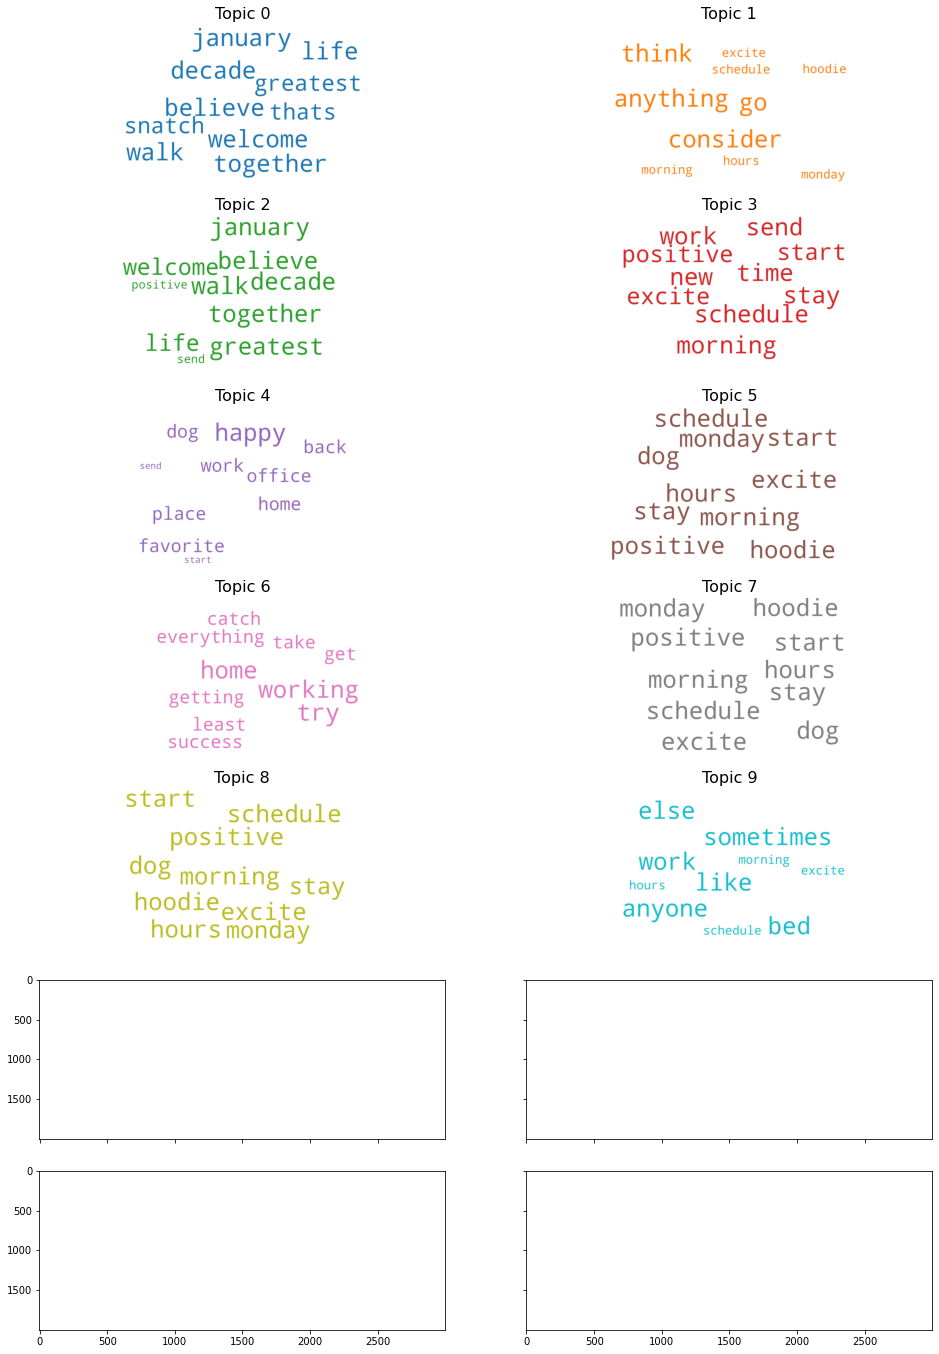

In [25]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=3000,
                  height=2000,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False,num_topics=13)

fig, axes = plt.subplots(7, 2, figsize=(16,24), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()